# Multi-step forecasting with feature engineering.

In the previous notebook, we lined up most feature engineering steps into a Scikit-learn pipeline and then created all features with one line of code. 

In this notebook, we will train a linear regression model that takes as input these new features, utilizing cross-validation with an expanding window.


## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline

# For the linear regression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from feature_engine.creation import CyclicalTransformer, MathematicalCombination
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import MeanMedianImputer

# Load Data

In [2]:
# Function to load and prepare input data.

def load_data():
    
    # Data lives here.
    filename = '../datasets/AirQualityUCI_ready.csv'

    # Load data: only the time variable and CO
    data = pd.read_csv(filename, usecols=['Date_Time', 'CO_sensor'])
        
    # Cast date variable in datetime format.
    data['Date_Time'] = pd.to_datetime(data['Date_Time'])

    # Set the index to the timestamp.
    data.index = data['Date_Time']

    # Sanity: sort index.
    data.sort_index(inplace=True)
    
    # Reduce data span.
    data = data[(
        data['Date_Time'] >= '2004-04-01') &
        (data['Date_Time'] <= '2005-04-30')
    ]
    
    # Remove outliers
    data = data.loc[(data['CO_sensor']>0)]
    
    return data

In [3]:
# Load data.

data = load_data()

data.head()

,Date_Time,CO_sensor
Date_Time,,
2004-04-04 00:00:00,2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,2004-04-04 04:00:00,1028.0


# Our Feature engineering classes

## Lag Features

In [4]:
class LagFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, features, frequency, label):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate which features to lag,
        # how much we should lag the variables, 
        # and the name for the new variables.
        
        self.features = features
        self.frequency = frequency
        self.label = label

    def fit(self, X, y=None):

        # We do not need to learn parameters

        return self

    def transform(self, X):

        # We lag the features

        # We make a copy not to over-write the original data
        X = X.copy()

        # Shift the data forward.
        tmp = X[self.features].shift(freq=self.frequency)

        # Name the new variables.
        tmp.columns = [v + self.label for v in self.features]

        # Add the variables to the original data.
        X = X.merge(tmp, left_index=True, right_index=True, how='left')

        return X

## Window features

In [5]:
class WindowFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, features, window, frequency):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the features to use for the computation
        # the size of the window,
        # and the frequency to shift forward.
        
        self.features = features
        self.window = window
        self.frequency = frequency

    def fit(self, X, y=None):

        # We do not need to learn parameters

        return self

    def transform(self, X):

        # First we calculate the average of the feature in
        # the indicated window, then we shift the value forward
        # based on the indicated frequency.

        X = X.copy()

        tmp = (X[self.features]
               .rolling(window=self.window).mean()
               .shift(freq=self.frequency)
               )

        # Rename the columns
        tmp.columns = [v + '_window' for v in self.features]

        # Add the variables to the original data.
        X = X.merge(tmp, left_index=True, right_index=True, how='left')

        return X

## Seasonality Features

Note that this is the only class that learns parameters from the data.

In [6]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's 
        # concentration per hour.

        # We make a copy of the dataframe 
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + '_season' for v in self.variables]
        
        # Ensure returned grouping is a dataframe
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()
        
        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature
        X = X.merge(self.seasonal_, on=self.season_var, how='left')
        
        # restore the datetime index to the df
        X.index = index

        return X

# Feature Engineering Pipeline

The same pipeline from the previous notebook.

In [7]:
engineering_pipe = Pipeline([

    # Extract datetime features
    ('datetime_features', DatetimeFeatures(
        features_to_extract=["month",
                             "week",
                             "day_of_week",
                             "day_of_month",
                             "hour",
                             "weekend",
                             ],
        drop_original=True)),

    # Lag Features
    ('lag_1', LagFeatures(['CO_sensor'], '1H', '_lag_1')),
    ('lag_24', LagFeatures(['CO_sensor'], '24H', '_lag_24')),

    # Window Features
    ('window_features', WindowFeatures(['CO_sensor'], '3H', '1H')),

    # Combine pollutants
    ('Combine', MathematicalCombination(

        # the variables to average
        variables_to_combine=['CO_sensor_lag_1', 'CO_sensor_lag_24'],

        # we indicate we want the average
        math_operations=['mean'],

        # the name of the new feature
        new_variables_names=['CO_lag_ave'],

        # what to do if the variables have NA
        missing_values='ignore',
    )),


    # Periodic features
    ('Periodic', CyclicalTransformer(
        variables=['Date_Time_month', 'Date_Time_hour'],
        drop_original=False)),

    # Missing Data Imputation
    ('imputer', MeanMedianImputer(
        # the variables to impute
        variables=[
            'CO_sensor_lag_1',
            'CO_sensor_lag_24',
            'CO_sensor_window',
            'CO_lag_ave',
        ],
    )),

    # Seasonal features
    ('seasonal', SeasonalTransformer(

        # the variable for the grouping
        season_var='Date_Time_hour',

        # the variables to group
        variables=['CO_sensor'],
    )),

])

# Split data into train and test

We "train" the model on a training set and evaluate its performance on a test set. This is good practice to avoid leaking information to the model and to conduct a fair evaluation on a completely new dataset.

In [8]:
# Split the data

X_train = data[data.index<='2005-03-04']
X_test = data[data.index>'2005-03-04']

X_train.shape, X_test.shape

((6851, 2), (542, 2))

In [9]:
# Feature engineering:
# create features from time series and
# timestamp

X_train_t = engineering_pipe.fit_transform(X_train)

In [10]:
# Lasso regression

lasso = Lasso(random_state=0)

# Train the model

lasso.fit(
    # the input features
    X_train_t.drop('CO_sensor',axis=1),
    
    # the target
    X_train_t['CO_sensor'],
)

Lasso(random_state=0)

In [11]:
# Make predictions

preds = lasso.predict(X_train_t.drop('CO_sensor',axis=1))

preds

array([1020.54285455, 1162.71072085, 1145.05338517, ..., 1227.34048564,
       1157.29925447, 1128.12395724])

Text(0.5, 1.0, 'Forecast')

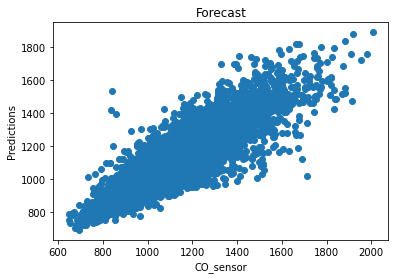

In [12]:
# Plot the predictions vs the truth.

plt.scatter(X_train['CO_sensor'], preds)
plt.xlabel('CO_sensor')
plt.ylabel('Predictions')
plt.title('Forecast')

## Capture the first hr prediction.

To carry out multi-step forecasting, we make the prediction for the next hour, and then that prediction is used to re-create all the features and determine the next prediction, and so on.

In [13]:
# Load data.

data = load_data()

# Split the data

X_train =  data[data.index < '2005-03-04']
X_test = data[data.index>='2005-03-04']

In [14]:
# Train the pipeline and the Regression 
# on the train set

X_train_t = engineering_pipe.fit_transform(X_train)

lasso.fit(
    # the input features
    X_train_t.drop('CO_sensor',axis=1),
    
    # the target
    X_train_t['CO_sensor'],
)

Lasso(random_state=0)

In [15]:
# Let's look a the last 3 values 
# in the train set.

X_train.tail(3)

,Date_Time,CO_sensor
Date_Time,,
2005-03-03 21:00:00,2005-03-03 21:00:00,1285.0
2005-03-03 22:00:00,2005-03-03 22:00:00,1206.0
2005-03-03 23:00:00,2005-03-03 23:00:00,1179.0


We need to add a row with the next timestamp to the train set, so that we can recreate the input features, using the historical values of the time series plus the timestamp.

In [16]:
# Create a mini dataframe with the next timestamp
# and no value in the CO_sensor variable.

step = {
    'Date_Time': [X_train.iloc[-1].name + pd.offsets.Hour(1)],
    'CO_sensor': [np.nan],
}

step = pd.DataFrame(step)

step.index = [X_train.iloc[-1].name + pd.offsets.Hour(1)]

step

,Date_Time,CO_sensor
2005-03-04,2005-03-04,NaN


In [17]:
# Append the mini dataframe to the 
# train set so that we can re-create 
# all features.

X_train = X_train.append(
        step, # the mini df
        ignore_index=False,
        verify_integrity=True,
        sort=True)

X_train.tail(3)

,CO_sensor,Date_Time
2005-03-03 22:00:00,1206.0,2005-03-03 22:00:00
2005-03-03 23:00:00,1179.0,2005-03-03 23:00:00
2005-03-04 00:00:00,NaN,2005-03-04 00:00:00


Now we have the first timestamp in the future, to re-create the date and time features. And the past details of the time series to recreate the lag, window and remaining features.

In [18]:
# Extract features

X_train_t = engineering_pipe.transform(X_train)

X_train_t.tail(3)

,CO_sensor,Date_Time_month,Date_Time_week,Date_Time_day_of_week,Date_Time_day_of_month,Date_Time_hour,Date_Time_weekend,CO_sensor_lag_1,CO_sensor_lag_24,CO_sensor_window,CO_lag_ave,Date_Time_month_sin,Date_Time_month_cos,Date_Time_hour_sin,Date_Time_hour_cos,CO_sensor_season
2005-03-03 22:00:00,1206.0,3,9,3,3,22,0,1285.0,1368.0,1384.666667,1326.5,1.0,6.123234e-17,-2.697968e-01,0.962917,1069.845070
2005-03-03 23:00:00,1179.0,3,9,3,3,23,0,1206.0,1195.0,1295.666667,1200.5,1.0,6.123234e-17,-2.449294e-16,1.000000,1066.597173
2005-03-04 00:00:00,NaN,3,9,4,4,0,0,1179.0,1047.0,1223.333333,1113.0,1.0,6.123234e-17,0.000000e+00,1.000000,1045.318021


In [19]:
# Make predictions

preds = lasso.predict(X_train_t.drop('CO_sensor',axis=1))

preds

array([1020.59106526, 1163.02899034, 1145.29949521, ..., 1227.50973249,
       1157.42836027, 1128.70723295])

The last value of the prediction should replace the NaN value in the train set. We will use that first prediction to re-create the features and be able to predict the second step in the future.

In [20]:
# Now we replace the NaN with its prediction.

X_train = X_train.fillna(preds[-1])

X_train.tail(3)

,CO_sensor,Date_Time
2005-03-03 22:00:00,1206.000000,2005-03-03 22:00:00
2005-03-03 23:00:00,1179.000000,2005-03-03 23:00:00
2005-03-04 00:00:00,1128.707233,2005-03-04 00:00:00


In [21]:
# Now we need to add another row with the new
# timestamp and NaN in the CO_sensor value

# Create the row.

step = {
    'Date_Time': [X_train.iloc[-1].name + pd.offsets.Hour(1)],
    'CO_sensor': [np.nan],
}

step = pd.DataFrame(step)

step.index = [X_train.iloc[-1].name + pd.offsets.Hour(1)]

step

,Date_Time,CO_sensor
2005-03-04 01:00:00,2005-03-04 01:00:00,NaN


In [22]:
# Add the row.

X_train = X_train.append(
        step,
        ignore_index=False,
        verify_integrity=True,
        sort=True)

X_train.tail(3)

,CO_sensor,Date_Time
2005-03-03 23:00:00,1179.000000,2005-03-03 23:00:00
2005-03-04 00:00:00,1128.707233,2005-03-04 00:00:00
2005-03-04 01:00:00,NaN,2005-03-04 01:00:00


In [23]:
# Create the new features
X_train_t = engineering_pipe.transform(X_train)

# Make predictions
preds = lasso.predict(X_train_t.drop('CO_sensor',axis=1))

preds

array([1020.59106526, 1163.02899034, 1145.29949521, ..., 1157.42836027,
       1128.70723295, 1078.97285759])

Now we have the prediction for the second hour. We continue like this until we predict various steps in the future.

## Forecasting 24 steps ahead.

Let's now go ahead and predict the next 24 hours of pollutant concentration.

We start by calculating the first hour concentration as we did previously, appending the value to the train set, and repeating this process 24 times.

In [24]:
# Load data.

data = load_data()

# Split the data

X_train =  data[data.index < '2005-03-04']
X_test = data[data.index>='2005-03-04']

In [25]:
# Train the pipeline and the Regression 
# on the train set

X_train_t = engineering_pipe.fit_transform(X_train)

lasso.fit(
    # the input features
    X_train_t.drop('CO_sensor',axis=1),
    
    # the target
    X_train_t['CO_sensor'],
)

Lasso(random_state=0)

In [26]:
# Now we predict pollutant concentration
# in the next 24 hs.

for i in range(24):

    # Create one step ahead.
    step = {
        'Date_Time': [X_train.iloc[-1].name + pd.offsets.Hour(1)],
        'CO_sensor': [np.nan],
    }

    step = pd.DataFrame(step)
    step.index = [X_train.iloc[-1].name + pd.offsets.Hour(1)]

    # Append the step to the data
    X_train = X_train.append(
        step,
        ignore_index=False,
        verify_integrity=True,
        sort=True)
    
    
    # Create the input features
    X_train_t = engineering_pipe.transform(X_train)

    # Make predictions
    preds = lasso.predict(X_train_t.drop('CO_sensor', axis=1))

    # Add the last prediction to the train set
    X_train = X_train.fillna(preds[-1])

<AxesSubplot:>

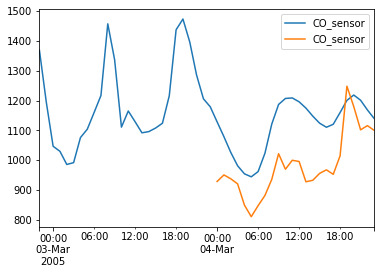

In [27]:
# We can plot our predictions vs. the truth, which is 
# the CO concentration in the test set.

tmp  = pd.concat([X_train.tail(50), X_test.head(24)], axis=1)

tmp['CO_sensor'].plot()

We see some improvement: this model seems to at least capture the seasonality.

# Back-testing with expanding window.

Now, we will make predictions with an expanding window. We will "train" the model up to a certain point, and then make predictions 24hs ahead. We will then "train" the model up to a point further in the future, and make predictions 24hs ahead. And so on.



<img src='../images/backtesting.png' width="600" height="600">


In [28]:
# Load data.

data = load_data()

# Split the data

X_train =  data[data.index < '2005-03-04']
X_test = data[data.index>='2005-03-04']

In [29]:
# Capture first day on test set

start = X_test.iloc[0].name
start

Timestamp('2005-03-04 00:00:00')

In [30]:
# Capture last day on test set

end = X_test.iloc[-1].name
end

Timestamp('2005-04-04 14:00:00')

In [31]:
# Create a 24 hr date range.

pd.date_range(start=start, end=end, freq='24H')

DatetimeIndex(['2005-03-04', '2005-03-05', '2005-03-06', '2005-03-07',
               '2005-03-08', '2005-03-09', '2005-03-10', '2005-03-11',
               '2005-03-12', '2005-03-13', '2005-03-14', '2005-03-15',
               '2005-03-16', '2005-03-17', '2005-03-18', '2005-03-19',
               '2005-03-20', '2005-03-21', '2005-03-22', '2005-03-23',
               '2005-03-24', '2005-03-25', '2005-03-26', '2005-03-27',
               '2005-03-28', '2005-03-29', '2005-03-30', '2005-03-31',
               '2005-04-01', '2005-04-02', '2005-04-03', '2005-04-04'],
              dtype='datetime64[ns]', freq='24H')

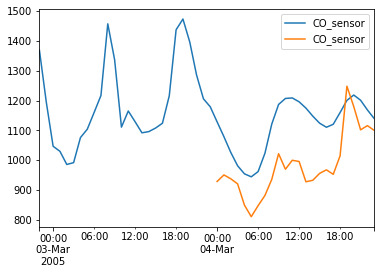

rmse:  151.86768439776108


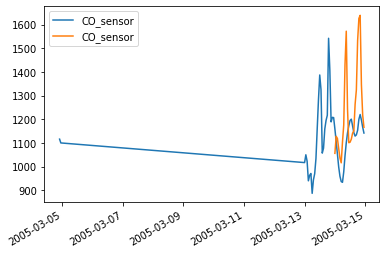

rmse:  212.56542014946248


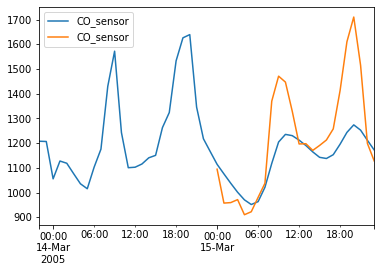

rmse:  167.82438174817042


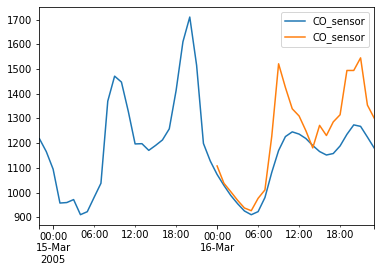

rmse:  141.03565759685134


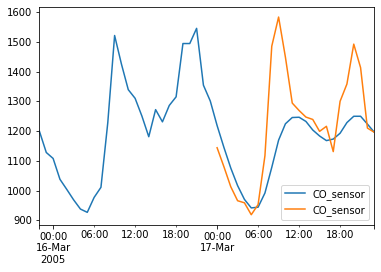

rmse:  150.25301688867526


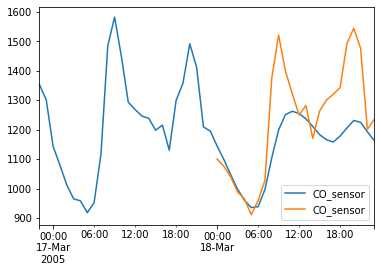

rmse:  149.6126845351349


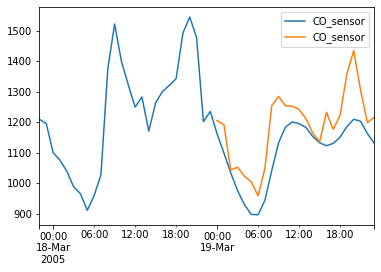

rmse:  101.81809310044602


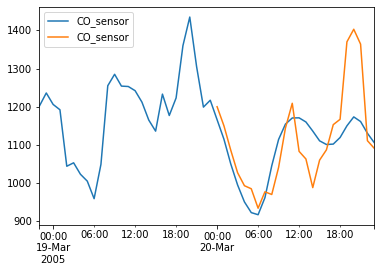

rmse:  94.25799606197222


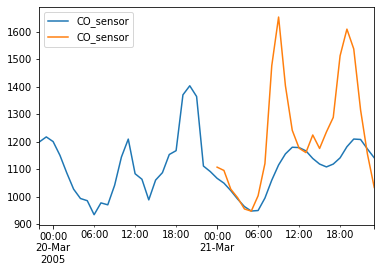

rmse:  209.93366693860594


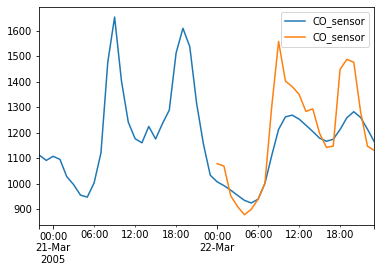

rmse:  125.61838833898487


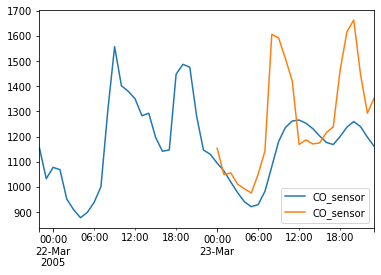

rmse:  212.668030305434


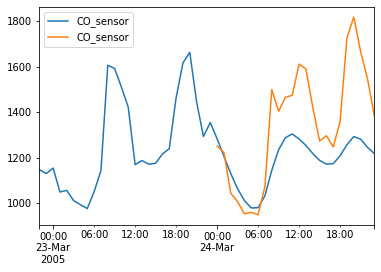

rmse:  233.87731484670047


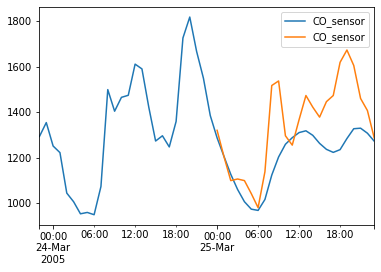

rmse:  190.0857951079869


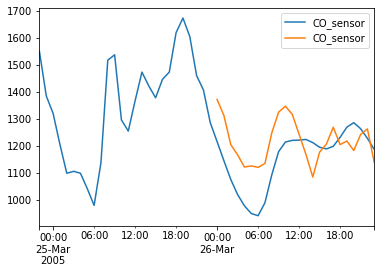

rmse:  113.80777391265923


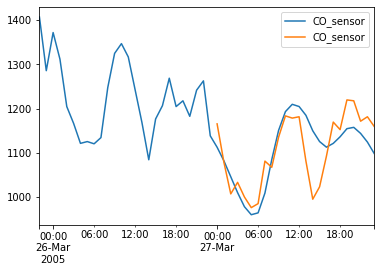

rmse:  56.5595223522114


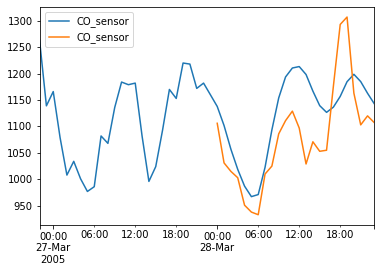

rmse:  77.65341033480554


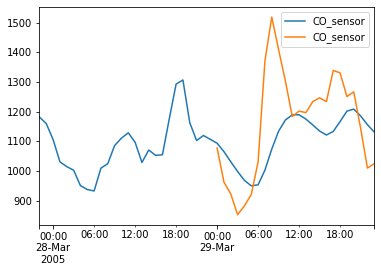

rmse:  161.40815059735746


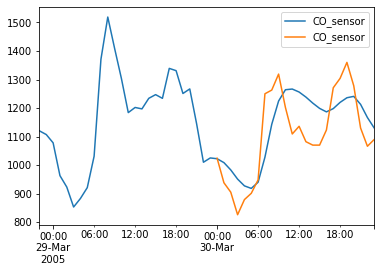

rmse:  104.03903057804729


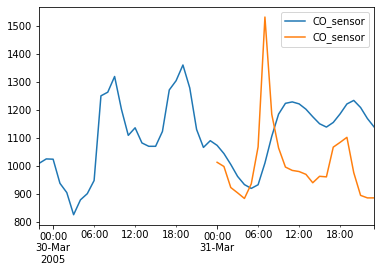

rmse:  205.6369663585285


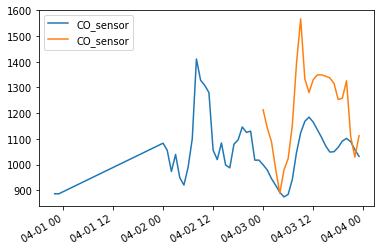

rmse:  204.77709435107576


In [32]:
# We loop, expanding the train set 24 hr.
# on each round.

# To collect the RMSE for each
# test set portion examined.
rmse_ls = []

for date in pd.date_range(start=start, end=end, freq='24H'):

    # Split the data:
    # Here we perform the expanding window.
    X_train = data[data.index < date]

    # We only select the next 24 hrs of real
    # Pollutant concentration.
    X_test = data[data.index >= date].head(24)

    # Train the pipeline
    # ==================
    X_train_t = engineering_pipe.fit_transform(X_train)

    lasso.fit(
        # the input features
        X_train_t.drop('CO_sensor', axis=1),

        # the target
        X_train_t['CO_sensor'],
    )

    # Multi-step forecast:
    for i in range(24):

        # Create one step ahead
        step = {
            'Date_Time': [X_train.iloc[-1].name + pd.offsets.Hour(1)],
            'CO_sensor': [np.nan],
        }

        step = pd.DataFrame(step)
        step.index = [X_train.iloc[-1].name + pd.offsets.Hour(1)]

        # Append the step to the data
        X_train = X_train.append(
            step,
            ignore_index=False,
            verify_integrity=True,
            sort=True)

        
        # Create the input features
        X_train_t = engineering_pipe.transform(X_train)

        # Make predictions
        preds = lasso.predict(X_train_t.drop('CO_sensor', axis=1))

        # Add the last prediction to the data set
        X_train = X_train.fillna(preds[-1])

        
    # Now, we check that the test set is aligned with
    # the 24 hr predictions.
    if X_train.index.max() == X_test.index.max():

        # Plot the predictions for every 24hs chunk.
        tmp = pd.concat([X_train.tail(50), X_test], axis=1)
        tmp['CO_sensor'].plot()
        plt.show()

        # We determine the RMSE.
        rmse_ = mean_squared_error(
            X_test['CO_sensor'], X_train['CO_sensor'].tail(24), squared=False,
        )
        print('rmse: ', rmse_)

        # Append the RMSE to our list
        rmse_ls.append(rmse_)

In [33]:
# Mean performance during cross-validation

print('rmse: ', np.mean(rmse_ls), '+-', np.std(rmse_ls))
print('Number of days evaluated: ', len(rmse_ls))

rmse:  153.26500392504354 +- 49.95063384181728
Number of days evaluated:  20


The performance in terms of the RMSE is somewhat similar to that obtain with the Linear regression using the lag feature as input. But by looking at the plots, we understand that this model follows more or less the ups and downs of the real concentration throughout the day, which the previous model could not do.


# Train final model

Now that we are happy with our model, we train it on the entire dataset and determine the feature importance.

In [34]:
# Load data.

data = load_data()

In [35]:
# Create the features
data = engineering_pipe.fit_transform(data)


# Fit the regression.
lasso.fit(
    # the input features
    data.drop('CO_sensor',axis=1),

    # the target
    data['CO_sensor'],
)

Lasso(random_state=0)

Text(0, 0.5, 'Importance')

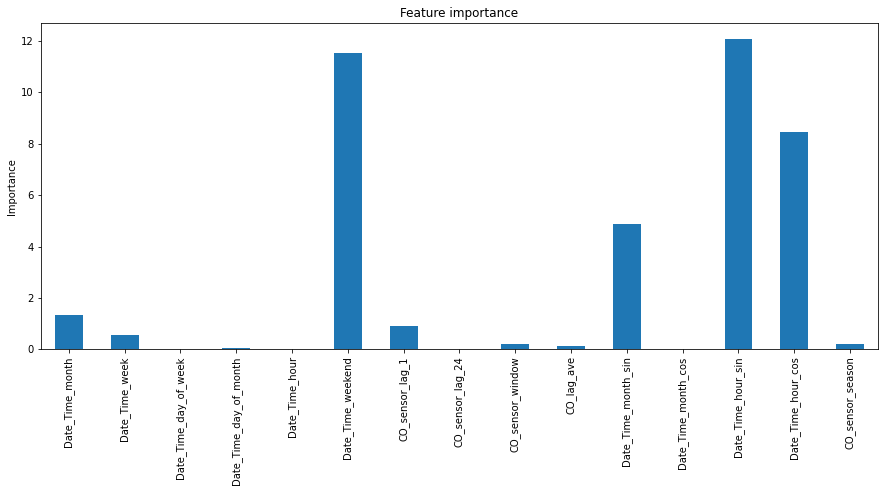

In [36]:
# Let's now plot the feature's importance

# The importance is stored in the estimator.
tmp = pd.Series(np.abs(lasso.coef_))

# Let's add the variable names.
tmp.index = data.drop('CO_sensor',axis=1).columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title('Feature importance')
plt.ylabel('Importance')

This model seems to capture the seasonality better because a lot of the time features contribute substantially to the prediction.